In [1]:
from nltk import word_tokenize
import nltk
import re
import tweepy as tw
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

#### Recuperando os dados que foram classificados

In [2]:
df = pd.read_csv('tweet_data_clf.csv',index_col=0)
df.head()

,full_text,sentiment
0,A CUFA está em todo território nacional e em ...,2
1,a segunda onda de covid tá vindo,2
2,Meus vizinhos encontraram a cura pro Covid e e...,1
3,"Papa Francisco disse que ""fofocar é uma praga...",2
4,Nem na quarentena fiquei sem sol. Por isso ac...,3


In [3]:
df.sentiment.value_counts()

1    56
2    40
3     4
Name: sentiment, dtype: int64

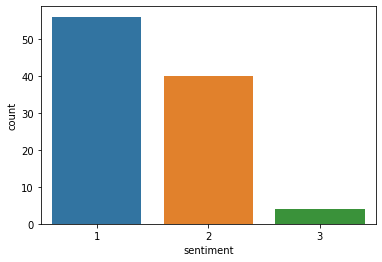

In [4]:
sns.countplot(df.sentiment);

Podemos ver um grande desbalanceamento entre a categoria positiva e as demais.

# Pré-Processamento dos Dados

#### Removendo Tweets duplicados

Ainda que na coleta dos dados tenham sido filtrados os retweets ainda assim foram recolhidos alguns tweets duplicados.

In [5]:
df.full_text.count()

100

In [6]:
df.drop_duplicates(['full_text'], inplace=True)
df.full_text.count()

97

#### Separando teste e treino.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)

#### Separando predictors e labels.

In [9]:
tweets = train_set.drop('sentiment',axis=1)
classe = train_set['sentiment'].copy()

In [10]:
def Preprocessing(instancia):
    # Remove caracteres indesejados.
    instancia = re.sub(r"#\S+", "", instancia)
    instancia = re.sub(r"@\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','').replace(',','')
    # Removendo palavras e termos frequentes que não tem relevância nos dados.
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [11]:
tweets = [Preprocessing(i) for i in tweets.full_text]

In [12]:
print('''Antes: {}

Depois: {}'''.format(train_set.full_text.iloc[0],tweets[0]))

Antes: Manos por favor, COVID não tem uma cláusula assinada na qual ele infectará o indivíduo APENAS se na reunião houver mais de 5 pessoas
Vejo gente criticando o bar até virar do avesso e reunindo com 4 pessoas que não moram c ela.

Aglomeração é mais questão de chance de contágio Zé

Depois: manos favor covid cláusula assinada infectará indivíduo apenas reunião 5 pessoas vejo gente criticando bar virar avesso reunindo 4 pessoas moram c aglomeração questão chance contágio zé


#### Tokenização

Usando a biblioteca nltk para tokenizar os tweets. Ou seja, dividir uma string ou textos em uma lista de tokens.

In [13]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer() 
tweet_tokenizer.tokenize(tweets[0])

['manos',
 'favor',
 'covid',
 'cláusula',
 'assinada',
 'infectará',
 'indivíduo',
 'apenas',
 'reunião',
 '5',
 'pessoas',
 'vejo',
 'gente',
 'criticando',
 'bar',
 'virar',
 'avesso',
 'reunindo',
 '4',
 'pessoas',
 'moram',
 'c',
 'aglomeração',
 'questão',
 'chance',
 'contágio',
 'zé']

In [14]:
# Instanciando o objeto que faz a vetorização dos dados de texto.
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

In [15]:
# Aplica o vetorizador nos dados de texto e retorna uma matriz esparsa:
freq_tweets = vectorizer.fit_transform(tweets)

Treinando um modelo de Naive Bayes

In [16]:
# Treino de modelo de Machine Learning:
modelo = MultinomialNB()
modelo.fit(freq_tweets,classe)

MultinomialNB()

Testando com alguns tweets do set de teste.

In [17]:
testes = list(test_set.iloc[1:4].full_text)
testes

[' Suspeita de covid more',
 '  Os casos de covid estão aumentando na Croácia. Rezando pra lenda não pegar 🙌🏽🙌🏽😭',
 'Tem umas pessoas que eu olho os storys e fico pensando COMO que nao pegou covid ainda????????']

In [18]:
# Transforma os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(testes)

In [19]:
# Fazendo a classificação com o modelo treinado:
for t, p, c in zip (testes,modelo.predict(freq_testes),test_set.iloc[1:4].sentiment):
    # t representa o tweet e p a predição de cada tweet e c a classifição humana.
    print ('''Tweet: {}
           Predição: {}
           Classificação humana: {}'''.format(t,c,p)) 

Tweet:  Suspeita de covid more
           Predição: 1
           Classificação humana: 1
Tweet:   Os casos de covid estão aumentando na Croácia. Rezando pra lenda não pegar 🙌🏽🙌🏽😭
           Predição: 1
           Classificação humana: 1
Tweet: Tem umas pessoas que eu olho os storys e fico pensando COMO que nao pegou covid ainda????????
           Predição: 1
           Classificação humana: 1


In [20]:
# Medindo a acurácia média do modelo:
teste_tweets = [Preprocessing(i) for i in test_set.full_text]
freq_teste_tweets = vectorizer.transform(teste_tweets)

resultados = modelo.predict(freq_teste_tweets)
classes = test_set.sentiment

metrics.accuracy_score(classes,resultados)

0.65

In [21]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predição'], margins=True))

Predição   1  2  All
Real                
1         10  2   12
2          4  3    7
3          1  0    1
All       15  5   20


In [22]:
# Medidas de validação do modelo:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,zero_division=0))

              precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.60      0.43      0.50         7
           3       0.00      0.00      0.00         1

    accuracy                           0.65        20
   macro avg       0.42      0.42      0.41        20
weighted avg       0.61      0.65      0.62        20



In [ ]:
import pickle

In [29]:
# Salvando o modelo e o vetorizador.
filename_modelo = 'modelo_class.sav'
pickle.dump(modelo, open(filename_modelo, 'wb'))

filename_vectorizer = 'vectorizer.sav'
pickle.dump(vectorizer, open(filename_vectorizer, 'wb'))

In [23]:
import pickle
s = pickle.dumps(modelo)

In [24]:
modelo2 = pickle.loads(s)